In [90]:
import spotipy
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import stats
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import train_test_split
import spotify
%load_ext autoreload
%autoreload 2

from config import (
    api_key_lastfm,
    client_secret_lastfm,
    client_id,
    client_secret,
    redirect_uri
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
### Get a dataframe with last tracks
df = spotify.get_recent_tracks(100)

In [222]:
### Vectorize data from this dataframe
df_vect = spotify.vectorize_recent_tracks(df, n_components=10, played_date=False)

In [223]:
df_scaled = spotify.scale_and_weight(df_vect, weighted_features=['popularity', 'release_date', 'album_id', 'track_tags', 'track_artists_id'], weights=[2, 2, 3, 2, 3], n_components=10)

In [224]:
clusters = spotify.clustering(df_vect)
df['cluster'] = clusters

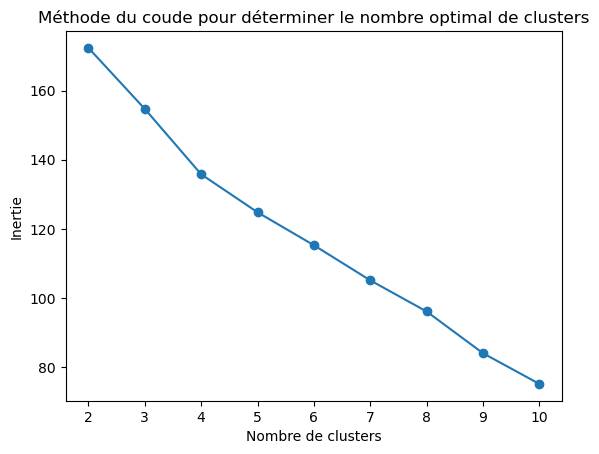

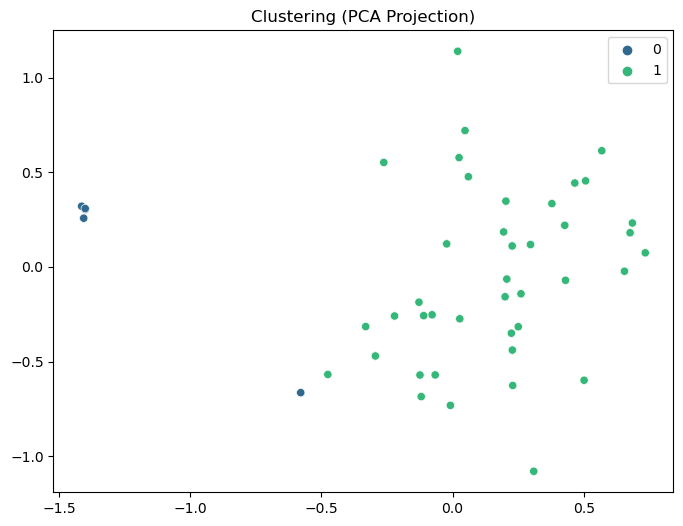

In [225]:
spotify.visualize_clustering(df_vect)

In [228]:
cluster_dfs = spotify.get_tracklist(df, limit=5)
cluster_vect_dfs = spotify.vectorize_tracklist(cluster_dfs, weighted_features=['popularity', 'release_date', 'album_id', 'track_tags', 'track_artists_id'], weights=[2, 2, 3, 2, 3], n_components=1)
cosine_matrices = spotify.compute_cosine_matrices(cluster_vect_dfs)

In [234]:
similar_tracks = spotify.search_similar_tracks(df, cluster_dfs, cosine_matrices, track_pos=7)
similar_tracks

"Tracks similaires à 'Boucan (feat. Franglish)' : On y va, Minimum ça, Charisme, Monaco, 17 MOOD"